#1. Data loading

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os

data2= "/content/drive/MyDrive/CS726_project/lesslabelled.zip"
data1= "/content/drive/MyDrive/CS726_project/largerdataset.zip"

zip_ref = zipfile.ZipFile(data2, 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
zip_ref.close()

zip_ref1 = zipfile.ZipFile(data1, 'r') #Opens the zip file in read mode
zip_ref1.extractall('/tmp') #Extracts the files into the /tmp folder
zip_ref1.close()

In [ ]:
len(os.listdir('/tmp/lesslabelled/'))

4319

#2. Our GAN implementation

In [ ]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [ ]:
# Root directory for dataset
dataroot = "/tmp/largerdataset/"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

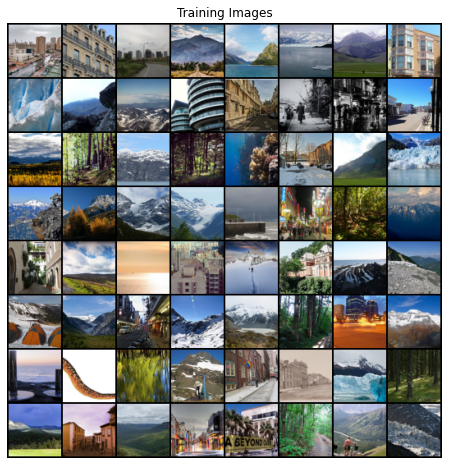

In [ ]:
dataset = dset.ImageFolder(root=dataroot, transform=transforms.Compose([transforms.Resize(image_size), transforms.CenterCrop(image_size), transforms.ToTensor(),
transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),    ]))

# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))




In [ ]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution

            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.LeakyReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.LeakyReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.LeakyReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.LeakyReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)


# class Generator(nn.Module):
#     def __init__(self):
#         super(Generator, self).__init__()

#         self.init_size = opt.img_size // 4
#         self.l1 = nn.Sequential(nn.Linear(opt.latent_dim, 128 * self.init_size ** 2))

#         self.conv_blocks = nn.Sequential(
#             nn.BatchNorm2d(128),
#             nn.Upsample(scale_factor=2),
#             nn.Conv2d(128, 128, 3, stride=1, padding=1),
#             nn.BatchNorm2d(128, 0.8),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Upsample(scale_factor=2),
#             nn.Conv2d(128, 64, 3, stride=1, padding=1),
#             nn.BatchNorm2d(64, 0.8),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Conv2d(64, opt.channels, 3, stride=1, padding=1),
#             nn.Tanh(),
#         )

#     def forward(self, noise):
#         out = self.l1(noise)
#         out = out.view(out.shape[0], 128, self.init_size, self.init_size)
#         img = self.conv_blocks(out)
#         return img

In [ ]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), pad

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [ ]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/5][0/191]	Loss_D: 1.5842	Loss_G: 0.7979	D(x): 0.3916	D(G(z)): 0.3413 / 0.4822
[0/5][50/191]	Loss_D: 0.2358	Loss_G: 4.2914	D(x): 0.8861	D(G(z)): 0.0071 / 0.0794
[0/5][100/191]	Loss_D: 0.1734	Loss_G: 6.8346	D(x): 0.8746	D(G(z)): 0.0025 / 0.0021
[0/5][150/191]	Loss_D: 0.4530	Loss_G: 2.6804	D(x): 0.7529	D(G(z)): 0.0650 / 0.1520
[1/5][0/191]	Loss_D: 0.5954	Loss_G: 2.5792	D(x): 0.9531	D(G(z)): 0.3368 / 0.1404
[1/5][50/191]	Loss_D: 0.2635	Loss_G: 3.5798	D(x): 0.8976	D(G(z)): 0.1125 / 0.0536
[1/5][100/191]	Loss_D: 0.3591	Loss_G: 4.4167	D(x): 0.9720	D(G(z)): 0.2500 / 0.0174
[1/5][150/191]	Loss_D: 0.1149	Loss_G: 4.5635	D(x): 0.9597	D(G(z)): 0.0659 / 0.0172
[2/5][0/191]	Loss_D: 2.3456	Loss_G: 6.2181	D(x): 0.2945	D(G(z)): 0.0002 / 0.0290
[2/5][50/191]	Loss_D: 0.2538	Loss_G: 6.4894	D(x): 0.9781	D(G(z)): 0.1806 / 0.0033
[2/5][100/191]	Loss_D: 0.0747	Loss_G: 5.4116	D(x): 0.9488	D(G(z)): 0.0179 / 0.0073
[2/5][150/191]	Loss_D: 0.1122	Loss_G: 4.2587	D(x): 0.9935	D(G(z)): 0.0

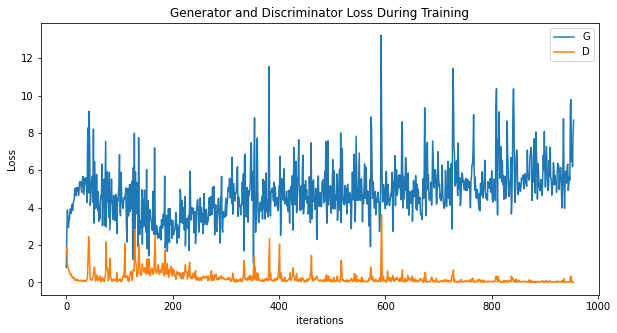

In [ ]:
#pickle.dump(netG, open('generator.pkl', 'wb'))
#pickle.dump(netD, open('discriminator.pkl', 'wb'))



plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

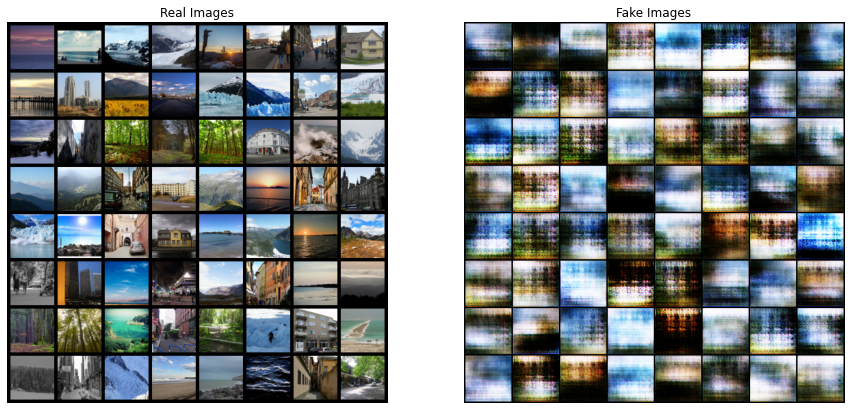

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

#Clip

Util

In [ ]:
import torch
import torchvision
from matplotlib import pyplot as plt

def save_grid(images, path):
    grid = torchvision.utils.make_grid(images)
    torchvision.utils.save_image(grid, path)

def show_grid(images):
    grid = torchvision.utils.make_grid(images)
    plt.imshow(grid.permute(1, 2, 0).cpu().detach().numpy())
    plt.show()

def biggan_norm(images):
    images = (images + 1) / 2.0
    images = images.clip(0, 1)
    return images

def biggan_denorm(images):
    images = images*2 - 1
    return images


def freeze_model(model):
    for param in model.parameters():
        param.requires_grad = False



Model

In [ ]:
!pip install pytorch_pretrained_biggan

import os
import sys
import torch
#from pytorch_pretrained_biggan import BigGAN as DMBigGAN
#import stylegan2

# from gpt2.model import GPT2LMHeadModel
# from gpt2.utils import load_weight
# from gpt2.config import GPT2Config
# from gpt2.sample import sample_sequence
# from gpt2.encoder import get_encoder


# class GPT2(torch.nn.Module):
#     def __init__(self, config):
#         super(GPT2, self).__init__()
#         self.config = config
#         if not os.path.exists(self.config.weights):
#             print("Weights not found!\nRun: ./download-weights.sh GPT2")
#             sys.exit(1)

#         state_dict = torch.load(self.config.weights, map_location=self.config.device)

#         self.enc = get_encoder(config)
#         self.model = GPT2LMHeadModel(GPT2Config())
#         self.model = load_weight(self.model, state_dict)
#         self.model.to(self.config.device)
#         self.model.eval()

#         self.init_tokens = torch.tensor(self.enc.encode(self.config.init_text)).to(self.config.device)

#     def parse_out(self, out):
#         texts = []
#         for seq in out:
#             if self.enc.encoder["<|endoftext|>"] in seq:
#                 text = seq[self.config.dim_z:seq.index(self.enc.encoder["<|endoftext|>"])]
#             else:
#                 text = seq[self.config.dim_z:]
#             text = self.enc.decode(text)

#             texts.append(text[:self.config.max_text_len])
#         return texts


#     def generate(self, z, minibatch=None):
#         #TODO: implement minibatch
#         init_tokens = self.init_tokens.repeat(z.shape[0], 1)
#         z = torch.cat((z, init_tokens), dim=1)

#         out = sample_sequence(
#             model=self.model,
#             length=self.config.max_tokens_len,
#             context=z,
#             start_token=None,
#             batch_size=self.config.batch_size,
#             temperature=0.7,
#             top_k=40,
#             device=self.config.device,
#             sample=self.config.stochastic
#         )

#         return self.parse_out(out)


# class DeepMindBigGAN(torch.nn.Module):
#     def __init__(self, config):
#         super(DeepMindBigGAN, self).__init__()
#         self.config = config
#         self.G = DMBigGAN.from_pretrained(config.weights)
#         self.D = None

#     def has_discriminator(self):
#         return False

#     def generate(self, z, class_labels, minibatch = None):
#         if minibatch is None:
#             return self.G(z, class_labels, self.config.truncation)
#         else:
#             assert z.shape[0] % minibatch == 0
#             gen_images = []
#             for i in range(0, z.shape[0] // minibatch):
#                 z_minibatch = z[i*minibatch:(i+1)*minibatch, :]
#                 cl_minibatch = class_labels[i*minibatch:(i+1)*minibatch, :]
#                 gen_images.append(self.G(z_minibatch, cl_minibatch, self.config.truncation))
#             gen_images = torch.cat(gen_images)
#             return gen_images

class OurGAN(torch.nn.Module):
    def __init__(self, config):
        super(OurGAN, self).__init__()
        if "OurGAN" in config.config:
          model = "church"
        self.G = stylegan2.models.load(os.path.join(config.weights, "G.pth"))
        self.D = stylegan2.models.load(os.path.join(config.weights, "D.pth"))

    def has_discriminator(self):
        return False

    def generate(self, z, minibatch = None):
        if minibatch is None:
            return netG(z)
        else:
            assert z.shape[0] % minibatch == 0
            gen_images = []
            for i in range(0, z.shape[0] // minibatch):
                z_minibatch = z[i*minibatch:(i+1)*minibatch, :]
                gen_images.append(netG(z_minibatch).detach().cpu())
            gen_images = torch.cat(gen_images)
            return gen_images

    def discriminate(self, images, minibatch = None):
        if minibatch is None:
            return netD(images)
        else:
            assert images.shape[0] % minibatch == 0
            discriminations = []
            for i in range(0, images.shape[0] // minibatch):
                images_minibatch = images[i*minibatch:(i+1)*minibatch, :]
                discriminations.append(netD(images_minibatch).view(-1))
            discriminations = torch.cat(discriminations)
            return discriminations

# class StyleGAN2(torch.nn.Module):
#     def __init__(self, config):
#         super(StyleGAN2, self).__init__()
#         if not os.path.exists(os.path.join(config.weights, "G.pth")):
#             if "ffhq" in config.config:
#                 model = "ffhq"
#             elif "car" in config.config:
#                 model = "car"
#             elif "church" in config.config:
#                 model = "church"
#             print("Weights not found!\nRun : ./download-weights.sh StyleGAN2-%s" % (model))
#             sys.exit(1)
#         self.G = stylegan2.models.load(os.path.join(config.weights, "G.pth"))
#         self.D = stylegan2.models.load(os.path.join(config.weights, "D.pth"))

#     def has_discriminator(self):
#         return True

#     def generate(self, z, minibatch = None):
#         if minibatch is None:
#             return self.G(z)
#         else:
#             assert z.shape[0] % minibatch == 0
#             gen_images = []
#             for i in range(0, z.shape[0] // minibatch):
#                 z_minibatch = z[i*minibatch:(i+1)*minibatch, :]
#                 gen_images.append(self.G(z_minibatch))
#             gen_images = torch.cat(gen_images)
#             return gen_images

#     def discriminate(self, images, minibatch = None):
#         if minibatch is None:
#             return self.D(images)
#         else:
#             assert images.shape[0] % minibatch == 0
#             discriminations = []
#             for i in range(0, images.shape[0] // minibatch):
#                 images_minibatch = images[i*minibatch:(i+1)*minibatch, :]
#                 discriminations.append(self.D(images_minibatch))
#             discriminations = torch.cat(discriminations)
#             return discriminations

In [ ]:
!pip install pytorch_pretrained_biggan

Latent

In [ ]:
import torch

from pytorch_pretrained_biggan import truncated_noise_sample

class DeepMindBigGANLatentSpace(torch.nn.Module):
    def __init__(self, config):
        super(DeepMindBigGANLatentSpace, self).__init__()
        self.config = config

        self.z = torch.nn.Parameter(torch.tensor(truncated_noise_sample(self.config.batch_size)).to(self.config.device))
        self.class_labels = torch.nn.Parameter(torch.rand(self.config.batch_size, self.config.num_classes).to(self.config.device))

    def set_values(self, z, class_labels):
        self.z.data = z
        self.class_labels.data = class_labels

    def set_from_population(self, x):
        self.z.data = torch.tensor(x[:,:self.config.dim_z].astype(float)).float().to(self.config.device)
        self.class_labels.data = torch.tensor(x[:,self.config.dim_z:].astype(float)).float().to(self.config.device)

    def forward(self):
        z = torch.clip(self.z, -2, 2)
        class_labels = torch.softmax(self.class_labels, dim=1)

        return z, class_labels


class StyleGAN2LatentSpace(torch.nn.Module):
    def __init__(self, config):
        super(StyleGAN2LatentSpace, self).__init__()
        self.config = config

        self.z = torch.nn.Parameter(torch.randn(self.config.batch_size, self.config.dim_z).to(self.config.device))

    def set_values(self, z):
        self.z.data = z

    def set_from_population(self, x):
        self.z.data = torch.tensor(x.astype(float)).float().to(self.config.device)

    def forward(self):
        return (self.z, )


class GPT2LatentSpace(torch.nn.Module):
    def __init__(self, config):
        super(GPT2LatentSpace, self).__init__()
        self.config = config

        self.z = torch.randint(0, self.config.encoder_size, size=(self.config.batch_size, self.config.dim_z)).to(self.config.device)
        #self.z = torch.zeros(self.config.batch_size, self.config.dim_z)

    def set_values(self, z):
        self.z.data = z

    def set_from_population(self, x):
        self.z.data = torch.tensor(x.astype(int)).long().to(self.config.device)

    def forward(self):
        return (self.z, )

class OurGANLatentSpace(torch.nn.Module):
    def __init__(self, config):
        super(OurGANLatentSpace, self).__init__()
        self.config = config
        self.z = torch.nn.Parameter(torch.randn(self.config.batch_size, self.config.dim_z).to(self.config.device))

    def set_values(self, z):
        self.z.data = z

    def set_from_population(self, x):
        self.z.data = torch.tensor(x.astype(int)).long().to(self.config.device)

    def forward(self):
        return (self.z, )

ImportError: ignored

Config

In [ ]:
from models import GPT2,DeepMindBigGAN,StyleGAN2

configs = dict(
    GPT2 = dict(
        task = "img2txt",
        dim_z = 20,
        max_tokens_len = 30,
        max_text_len = 50,
        encoder_size = 50257,
        latent = GPT2LatentSpace,
        model = GPT2,
        use_discriminator = False,
        init_text = "the picture of",
        weights = "./gpt2/weights/gpt2-pytorch_model.bin",
        encoder = "./gpt2/weights/encoder.json",
        vocab = "./gpt2/weights/vocab.bpe",
        stochastic = False,
        algorithm = "ga",
        pop_size = 100,
        batch_size = 25,
        problem_args = dict(
            n_var = 20,
            n_obj = 1,
            n_constr = 20,
            xl = 0,
            xu = 50256
        )
    ),
    DeepMindBigGAN256 = dict(
        task = "txt2img",
        dim_z = 128,
        num_classes = 1000,
        latent = DeepMindBigGANLatentSpace,
        model = DeepMindBigGAN,
        weights = "biggan-deep-256",
        use_discriminator = False,
        algorithm = "ga",
        norm = biggan_norm,
        denorm = biggan_denorm,
        truncation = 1.0,
        pop_size = 64,
        batch_size = 32,
        problem_args = dict(
            n_var = 128 + 1000,
            n_obj = 1,
            n_constr = 128,
            xl = -2,
            xu = 2
        )
    ),
    DeepMindBigGAN512 = dict(
        task = "txt2img",
        dim_z = 128,
        num_classes = 1000,
        latent = DeepMindBigGANLatentSpace,
        model = DeepMindBigGAN,
        weights = "biggan-deep-512",
        use_discriminator = False,
        algorithm = "ga",
        norm = biggan_norm,
        denorm = biggan_denorm,
        truncation = 1.0,
        pop_size = 32,
        batch_size = 8,
        problem_args = dict(
            n_var = 128 + 1000,
            n_obj = 1,
            n_constr = 128,
            xl = -2,
            xu = 2
        )
    ),
    StyleGAN2_ffhq_d = dict(
        task = "txt2img",
        dim_z = 512,
        latent = StyleGAN2LatentSpace,
        model = StyleGAN2,
        use_discriminator = True,
        weights = "./stylegan2/weights/ffhq-config-f",
        algorithm = "nsga2",
        norm = biggan_norm,
        denorm = biggan_denorm,
        pop_size = 16,
        batch_size = 4,
        problem_args = dict(
            n_var = 512,
            n_obj = 2,
            n_constr = 512,
            xl = -10,
            xu = 10,
        ),
    ),
    StyleGAN2_car_d = dict(
        task = "txt2img",
        dim_z = 512,
        latent = StyleGAN2LatentSpace,
        model = StyleGAN2,
        use_discriminator = True,
        weights = "./stylegan2/weights/car-config-f",
        algorithm = "nsga2",
        norm = biggan_norm,
        denorm = biggan_denorm,
        pop_size = 16,
        batch_size = 4,
        problem_args = dict(
            n_var = 512,
            n_obj = 2,
            n_constr = 512,
            xl = -10,
            xu = 10
        ),
    ),
    StyleGAN2_church_d = dict(
        task = "txt2img",
        dim_z = 512,
        latent = StyleGAN2LatentSpace,
        model = StyleGAN2,
        use_discriminator = True,
        weights = "./stylegan2/weights/church-config-f",
        algorithm = "nsga2",
        norm = biggan_norm,
        denorm = biggan_denorm,
        pop_size = 16,
        batch_size = 4,
        problem_args = dict(
            n_var = 512,
            n_obj = 2,
            n_constr = 512,
            xl = -10,
            xu = 10
        ),
    ),
    StyleGAN2_ffhq_nod = dict(
        task = "txt2img",
        dim_z = 512,
        latent = StyleGAN2LatentSpace,
        model = StyleGAN2,
        use_discriminator = False,
        weights = "./stylegan2/weights/ffhq-config-f",
        algorithm = "ga",
        norm = biggan_norm,
        denorm = biggan_denorm,
        pop_size = 16,
        batch_size = 4,
        problem_args = dict(
            n_var = 512,
            n_obj = 1,
            n_constr = 512,
            xl = -10,
            xu = 10
        )
    ),
    StyleGAN2_car_nod = dict(
        task = "txt2img",
        dim_z = 512,
        latent = StyleGAN2LatentSpace,
        model = StyleGAN2,
        use_discriminator = False,
        weights = "./stylegan2/weights/car-config-f",
        algorithm = "ga",
        norm = biggan_norm,
        denorm = biggan_denorm,
        pop_size = 16,
        batch_size = 4,
        problem_args = dict(
            n_var = 512,
            n_obj = 1,
            n_constr = 512,
            xl = -10,
            xu = 10
        )
    ),
    StyleGAN2_church_nod = dict(
        task = "txt2img",
        dim_z = 512,
        latent = StyleGAN2LatentSpace,
        model = StyleGAN2,
        use_discriminator = False,
        weights = "./stylegan2/weights/church-config-f",
        algorithm = "ga",
        norm = biggan_norm,
        denorm = biggan_denorm,
        pop_size = 16,
        batch_size = 4,
        problem_args = dict(
            n_var = 512,
            n_obj = 1,
            n_constr = 512,
            xl = -10,
            xu = 10
        )
    ),
    OurGAN = dict(
        task = "txt2img",
        dim_z = 512,
        latent = OurGANLatentSpace,
        model = OurGAN,
        use_discriminator = False,
        weights = "./stylegan2/weights/church-config-f",
        algorithm = "nsga2",
        norm = biggan_norm,
        denorm = biggan_denorm,
        pop_size = 16,
        batch_size = 4,
        problem_args = dict(
            n_var = 512,
            n_obj = 1,
            n_constr = 512,
            xl = -1,
            xu = 1
        )
    )
)

def get_config(name):
    return configs[name]

Generator

In [ ]:
import torch
from pytorch_pretrained_biggan import BigGAN
from clip import clip
import kornia
from PIL import Image
from torchvision.utils import save_image

image_size = 224

class Generator:
    def __init__(self, config):
        self.config = config
        self.augmentation = None

        self.CLIP, clip_preprocess = clip.load("ViT-B/32", device=self.config.device, jit=False)
        self.CLIP = self.CLIP.eval()
        freeze_model(self.CLIP)
        self.model = self.config.model(config).to(self.config.device).eval()
        freeze_model(self.model)

        if config.task == "txt2img":
            self.tokens = clip.tokenize([self.config.target]).to(self.config.device)
            self.text_features = self.CLIP.encode_text(self.tokens).detach()
        if config.task == "img2txt":
            image = clip_preprocess(Image.open(self.config.target)).unsqueeze(0).to(self.config.device)
            self.image_features = self.CLIP.encode_image(image)

    def generate(self, ls, minibatch=None):
        z = ls()
        result = self.model.generate(*z, minibatch=minibatch)
        if hasattr(self.config, "norm"):
            result = self.config.norm(result)
        return result

    def discriminate(self, images, minibatch=None):
        images = self.config.denorm(images)
        return self.model.discriminate(images, minibatch)

    def has_discriminator(self):
        return self.model.has_discriminator()

    def clip_similarity(self, input):
        if self.config.task == "txt2img":
            image = kornia.resize(input, (image_size, image_size))
            if self.augmentation is not None:
                image = self.augmentation(image)

            image_features = self.CLIP.encode_image(image)

            sim = torch.cosine_similarity(image_features, self.text_features)
        elif self.config.task == "img2txt":
            try:
                text_tokens = clip.tokenize(input).to(self.config.device)
            except:
                return torch.zeros(len(input))
            text_features = self.CLIP.encode_text(text_tokens)

            sim = torch.cosine_similarity(text_features, self.image_features)
        return sim


    def save(self, input, path):
        if self.config.task == "txt2img":
            if input.shape[0] > 1:
                save_grid(input.detach().cpu(), path)
            else:
                save_image(input[0], path)
        elif self.config.task == "img2txt":
            f = open(path, "w")
            f.write("\n".join(input))
            f.close()

Problem

In [ ]:
import numpy as np
import torch
from pymoo.model.problem import Problem

class GenerationProblem(Problem):
    def __init__(self, config):
        self.generator = Generator(config)
        self.config = config

        super().__init__(**self.config.problem_args)

    def _evaluate(self, x, out, *args, **kwargs):
        ls = self.config.latent(self.config)
        ls.set_from_population(x)

        with torch.no_grad():
            generated = self.generator.generate(ls, minibatch=self.config.batch_size)
            sim = self.generator.clip_similarity(generated).cpu().numpy()
            if self.config.problem_args["n_obj"] == 2 and self.config.use_discriminator:
                dis = self.generator.discriminate(generated, minibatch=self.config.batch_size)
                hinge = torch.relu(1 - dis)
                hinge = hinge.squeeze(1).cpu().numpy()
                out["F"] = np.column_stack((-sim, hinge))
            else:
                out["F"] = -sim

            out["G"] = np.zeros((x.shape[0]))


Operators

In [ ]:
import numpy as np
import torch
from scipy.stats import truncnorm

from pymoo.factory import get_sampling, get_crossover, get_mutation
from pymoo.operators.mixed_variable_operator import MixedVariableSampling, MixedVariableMutation, MixedVariableCrossover
from pymoo.model.sampling import Sampling

class TruncatedNormalRandomSampling(Sampling):
    def __init__(self, var_type=np.float):
        super().__init__()
        self.var_type = var_type

    def _do(self, problem, n_samples, **kwargs):
        return truncnorm.rvs(-2, 2, size=(n_samples, problem.n_var)).astype(np.float32)

class NormalRandomSampling(Sampling):
    def __init__(self, mu=0, std=1, var_type=np.float):
        super().__init__()
        self.mu = mu
        self.std = std
        self.var_type = var_type

    def _do(self, problem, n_samples, **kwargs):
        return np.random.normal(self.mu, self.std, size=(n_samples, problem.n_var))

class BinaryRandomSampling(Sampling):
    def __init__(self, prob=0.5):
        super().__init__()
        self.prob = prob

    def _do(self, problem, n_samples, **kwargs):
        val = np.random.random((n_samples, problem.n_var))
        return (val < self.prob).astype(np.bool)


def get_operators(config):
    if config.config == "DeepMindBigGAN256" or config.config == "DeepMindBigGAN512":
        mask = ["real"]*config.dim_z + ["bool"]*config.num_classes

        real_sampling = None
        if config.config == "DeepMindBigGAN256" or config.config == "DeepMindBigGAN512":
            real_sampling = TruncatedNormalRandomSampling()

        sampling = MixedVariableSampling(mask, {
            "real": real_sampling,
            "bool": BinaryRandomSampling(prob=5/1000)
        })

        crossover = MixedVariableCrossover(mask, {
            "real": get_crossover("real_sbx", prob=1.0, eta=3.0),
            "bool": get_crossover("bin_hux", prob=0.2)
        })

        mutation = MixedVariableMutation(mask, {
            "real": get_mutation("real_pm", prob=0.5, eta=3.0),
            "bool": get_mutation("bin_bitflip", prob=10/1000)
        })

        return dict(
            sampling=sampling,
            crossover=crossover,
            mutation=mutation
        )

    elif config.config.split("_")[0] == "StyleGAN2":
        return dict(
            sampling=NormalRandomSampling(),
            crossover=get_crossover("real_sbx", prob=1.0, eta=3.0),
            mutation=get_mutation("real_pm", prob=0.5, eta=3.0)
        )

    elif config.config == "GPT2":
        return dict(
            sampling=get_sampling("int_random"),
            crossover=get_crossover("int_sbx", prob=1.0, eta=3.0),
            mutation=get_mutation("int_pm", prob=0.5, eta=3.0)
        )
    elif config.config == "OurGAN":
        return dict(
            sampling=get_sampling("int_random"),
            crossover=get_crossover("int_sbx", prob=1.0, eta=3.0),
            mutation=get_mutation("int_pm", prob=0.5, eta=3.0)
        )

    else:
        raise Exception("Unknown config")

In [ ]:
import argparse
import os
import torch
import numpy as np
import pickle
from pymoo.optimize import minimize
from pymoo.algorithms.so_genetic_algorithm import GA
from pymoo.factory import get_algorithm, get_decision_making, get_decomposition
from pymoo.visualization.scatter import Scatter
import torchvision
from IPython.display import Image, display
import urllib.request

target = "Car"
config = "StyleGAN2_car_nod"
save_each = 10
generations = 10

if config == "GPT2":
  try:
    urllib.request.urlretrieve(target, "./target")
    target = "./target"
  except Exception as e:
    print(e)
    raise Exception("Target must be a vaild URL when using GPT2")

if "ffhq" in config:
  ! ./download-weights.sh StyleGAN2-ffhq
if "church" in config:
  ! ./download-weights.sh StyleGAN2-church
if "car" in config:
  ! ./download-weights.sh StyleGAN2-car
if config == "GPT2":
  ! ./download-weights.sh GPT2
if config == "OurGAN":
  ! ./download-weights.sh StyleGAN2-church

config = argparse.Namespace(
    config=config,
    target=target,
    device="cuda",
    generations=generations,
    save_each=save_each,
    tmp_folder="./tmp"
)

vars(config).update(get_config(config.config))

iteration = 0
def save_callback(algorithm):
    global iteration
    global config

    iteration += 1
    if iteration % config.save_each == 0 or iteration == config.generations:
        if config.problem_args["n_obj"] == 1:
            sortedpop = sorted(algorithm.pop, key=lambda p: p.F)
            X = np.stack([p.X for p in sortedpop])
        else:
            X = algorithm.pop.get("X")

        ls = config.latent(config)
        ls.set_from_population(X)

        with torch.no_grad():
            generated = algorithm.problem.generator.generate(ls, minibatch=config.batch_size)
            name = "genetic-it-%d.jpg" % (iteration) if iteration < config.generations else "genetic-it-final.jpg"

            if config.task == "txt2img":
                algorithm.problem.generator.save(generated, os.path.join(config.tmp_folder, name))
                display(Image(os.path.join(config.tmp_folder, name)))
            elif config.task == "img2txt":
                print("\n".join(generated))


problem = GenerationProblem(config)
operators = get_operators(config)

if not os.path.exists(config.tmp_folder): os.mkdir(config.tmp_folder)

algorithm = get_algorithm(
    config.algorithm,
    pop_size=config.pop_size,
    sampling=operators["sampling"],
    crossover=operators["crossover"],
    mutation=operators["mutation"],
    eliminate_duplicates=True,
    callback=save_callback,
    **(config.algorithm_args[config.algorithm] if "algorithm_args" in config and config.algorithm in config.algorithm_args else dict())
)

res = minimize(
    problem,
    algorithm,
    ("n_gen", config.generations),
    save_history=False,
    verbose=True,
)


pickle.dump(dict(
    X = res.X,
    F = res.F,
    G = res.G,
    CV = res.CV,
), open(os.path.join(config.tmp_folder, "genetic_result"), "wb"))


if config.problem_args["n_obj"] == 1:
    X = np.atleast_2d(res.X)
else:
    try:
        result = get_decision_making("pseudo-weights", [0, 1]).do(res.F)
    except:
        print("Warning: cant use pseudo-weights")
        result = get_decomposition("asf").do(res.F, [0, 1]).argmin()
    X = res.X[result]
    X = np.atleast_2d(X)

print("="*50)
print("RESULT")
print("="*50)


ls = config.latent(config)
ls.set_from_population(X)

with torch.no_grad():
    generated = problem.generator.generate(ls)

if config.task == "txt2img":
    problem.generator.save(generated, os.path.join(config.tmp_folder, "output.jpg"))
    display(Image(os.path.join(config.tmp_folder, "output.jpg")))
elif config.task == "img2txt":
    print(generated)



#3. Integration with CLIP

In [ ]:
import argparse
import os
import torch
import numpy as np
import pickle
from pymoo.optimize import minimize
from pymoo.algorithms.so_genetic_algorithm import GA
from pymoo.factory import get_algorithm, get_decision_making, get_decomposition
from pymoo.visualization.scatter import Scatter
import torchvision
from IPython.display import Image, display
import urllib.request


from config import get_config
from problem import GenerationProblem
from operators import get_operators

target = "beautiful forest"
config = "DeepMindBigGAN256"
save_each = 10
generations = 10

if config == "GPT2":
  try:
    urllib.request.urlretrieve(target, "./target")
    target = "./target"
  except Exception as e:
    print(e)
    raise Exception("Target must be a vaild URL when using GPT2")


if "ffhq" in config:
  ! ./download-weights.sh StyleGAN2-ffhq
if "church" in config:
  ! ./download-weights.sh StyleGAN2-church
if "car" in config:
  ! ./download-weights.sh StyleGAN2-car
if config == "GPT2":
  ! ./download-weights.sh GPT2
#if config == "OurGAN":


config = argparse.Namespace(
    config=config,
    target=target,
    device="cuda",
    generations=generations,
    save_each=save_each,
    tmp_folder="./tmp"
)

vars(config).update(get_config(config.config))


iteration = 0
def save_callback(algorithm):
    global iteration
    global config

    iteration += 1
    if iteration % config.save_each == 0 or iteration == config.generations:
        if config.problem_args["n_obj"] == 1:
            sortedpop = sorted(algorithm.pop, key=lambda p: p.F)
            X = np.stack([p.X for p in sortedpop])
        else:
            X = algorithm.pop.get("X")

        ls = config.latent(config)
        ls.set_from_population(X)

        with torch.no_grad():
            generated = algorithm.problem.generator.generate(ls, minibatch=config.batch_size)
            name = "genetic-it-%d.jpg" % (iteration) if iteration < config.generations else "genetic-it-final.jpg"

            if config.task == "txt2img":
                algorithm.problem.generator.save(generated, os.path.join(config.tmp_folder, name))
                display(Image(os.path.join(config.tmp_folder, name)))
            elif config.task == "img2txt":
                print("\n".join(generated))


problem = GenerationProblem(config)
operators = get_operators(config)

if not os.path.exists(config.tmp_folder): os.mkdir(config.tmp_folder)

algorithm = get_algorithm(
    config.algorithm,
    pop_size=config.pop_size,
    sampling=operators["sampling"],
    crossover=operators["crossover"],
    mutation=operators["mutation"],
    eliminate_duplicates=True,
    callback=save_callback,
    **(config.algorithm_args[config.algorithm] if "algorithm_args" in config and config.algorithm in config.algorithm_args else dict())
)

res = minimize(
    problem,
    algorithm,
    ("n_gen", config.generations),
    save_history=False,
    verbose=True,
)


pickle.dump(dict(
    X = res.X,
    F = res.F,
    G = res.G,
    CV = res.CV,
), open(os.path.join(config.tmp_folder, "genetic_result"), "wb"))


if config.problem_args["n_obj"] == 1:
    X = np.atleast_2d(res.X)
else:
    try:
        result = get_decision_making("pseudo-weights", [0, 1]).do(res.F)
    except:
        print("Warning: cant use pseudo-weights")
        result = get_decomposition("asf").do(res.F, [0, 1]).argmin()
    X = res.X[result]
    X = np.atleast_2d(X)

print("="*50)
print("RESULT")
print("="*50)


ls = config.latent(config)
ls.set_from_population(X)

with torch.no_grad():
    generated = problem.generator.generate(ls)

if config.task == "txt2img":
    problem.generator.save(generated, os.path.join(config.tmp_folder, "output.jpg"))
    display(Image(os.path.join(config.tmp_folder, "output.jpg")))
elif config.task == "img2txt":
    print(generated)



#Trial

In [ ]:
import argparse
import os
import torch
import numpy as np
import pickle
from pymoo.optimize import minimize
from pymoo.algorithms.so_genetic_algorithm import GA
from pymoo.factory import get_algorithm, get_decision_making, get_decomposition
from pymoo.visualization.scatter import Scatter
import torchvision
from IPython.display import Image, display
import urllib.request

target = "Car"
config = "StyleGAN2_car_nod"
save_each = 10
generations = 10

if config == "GPT2":
  try:
    urllib.request.urlretrieve(target, "./target")
    target = "./target"
  except Exception as e:
    print(e)
    raise Exception("Target must be a vaild URL when using GPT2")

if "ffhq" in config:
  ! ./download-weights.sh StyleGAN2-ffhq
if "church" in config:
  ! ./download-weights.sh StyleGAN2-church
if "car" in config:
  ! ./download-weights.sh StyleGAN2-car
if config == "GPT2":
  ! ./download-weights.sh GPT2
if config == "OurGAN":
  ! ./download-weights.sh StyleGAN2-church

config = argparse.Namespace(
    config=config,
    target=target,
    device="cuda",
    generations=generations,
    save_each=save_each,
    tmp_folder="./tmp"
)

vars(config).update(get_config(config.config))

iteration = 0
def save_callback(algorithm):
    global iteration
    global config

    iteration += 1
    if iteration % config.save_each == 0 or iteration == config.generations:
        if config.problem_args["n_obj"] == 1:
            sortedpop = sorted(algorithm.pop, key=lambda p: p.F)
            X = np.stack([p.X for p in sortedpop])
        else:
            X = algorithm.pop.get("X")

        ls = config.latent(config)
        ls.set_from_population(X)

        with torch.no_grad():
            generated = algorithm.problem.generator.generate(ls, minibatch=config.batch_size)
            name = "genetic-it-%d.jpg" % (iteration) if iteration < config.generations else "genetic-it-final.jpg"

            if config.task == "txt2img":
                algorithm.problem.generator.save(generated, os.path.join(config.tmp_folder, name))
                display(Image(os.path.join(config.tmp_folder, name)))
            elif config.task == "img2txt":
                print("\n".join(generated))


problem = GenerationProblem(config)
operators = get_operators(config)

if not os.path.exists(config.tmp_folder): os.mkdir(config.tmp_folder)

algorithm = get_algorithm(
    config.algorithm,
    pop_size=config.pop_size,
    sampling=operators["sampling"],
    crossover=operators["crossover"],
    mutation=operators["mutation"],
    eliminate_duplicates=True,
    callback=save_callback,
    **(config.algorithm_args[config.algorithm] if "algorithm_args" in config and config.algorithm in config.algorithm_args else dict())
)

res = minimize(
    problem,
    algorithm,
    ("n_gen", config.generations),
    save_history=False,
    verbose=True,
)


pickle.dump(dict(
    X = res.X,
    F = res.F,
    G = res.G,
    CV = res.CV,
), open(os.path.join(config.tmp_folder, "genetic_result"), "wb"))


if config.problem_args["n_obj"] == 1:
    X = np.atleast_2d(res.X)
else:
    try:
        result = get_decision_making("pseudo-weights", [0, 1]).do(res.F)
    except:
        print("Warning: cant use pseudo-weights")
        result = get_decomposition("asf").do(res.F, [0, 1]).argmin()
    X = res.X[result]
    X = np.atleast_2d(X)

print("="*50)
print("RESULT")
print("="*50)


ls = config.latent(config)
ls.set_from_population(X)

with torch.no_grad():
    generated = problem.generator.generate(ls)

if config.task == "txt2img":
    problem.generator.save(generated, os.path.join(config.tmp_folder, "output.jpg"))
    display(Image(os.path.join(config.tmp_folder, "output.jpg")))
elif config.task == "img2txt":
    print(generated)

